# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d18/93c648398ff85fad51308f4ff8d11c2e8d8e66392462ffe79f3fb628.csv`. The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Kaohsiung City, Kaohsiung, Taiwan**, and the stations the data comes from are shown on the map below.

In [1]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd
import numpy as np
import datetime
%matplotlib notebook

### Read data

In [2]:
url = 'data/C2A2_data/BinnedCsvs_d18/93c648398ff85fad51308f4ff8d11c2e8d8e66392462ffe79f3fb628.csv'
df = pd.read_csv(url)
df.head()

,ID,Date,Element,Data_Value
0,JA000047899,2007-12-03,TMAX,158
1,JA000047936,2013-11-12,TMAX,215
2,JA000047675,2011-11-25,TMIN,75
3,JA000047662,2006-08-27,TMAX,272
4,JA000047604,2010-08-22,TMAX,330


### Preparing the Data for Visualization

In [3]:
# convert the temperature shown (tenths of degrees C) to the right temperature 
df['Data_Value'] *= 0.1

# add column 'Year' and 'M-D' (Month-Date)
zip_generator = df['Date'].apply(lambda string: (string[0:4], string[5:]))
df['Year'], df['M-D'] = zip(*zip_generator)

# remove all 02-29 for convenience
df = df[df['M-D'] != '02-29']
df.head()

,ID,Date,Element,Data_Value,Year,M-D
0,JA000047899,2007-12-03,TMAX,15.8,2007,12-03
1,JA000047936,2013-11-12,TMAX,21.5,2013,11-12
2,JA000047675,2011-11-25,TMIN,7.5,2011,11-25
3,JA000047662,2006-08-27,TMAX,27.2,2006,08-27
4,JA000047604,2010-08-22,TMAX,33.0,2010,08-22


In [4]:
# drop unnecessary columns 'ID' and 'Date'
df.drop(['ID', 'Date'], axis = 1, inplace = True)
df.head()

,Element,Data_Value,Year,M-D
0,TMAX,15.8,2007,12-03
1,TMAX,21.5,2013,11-12
2,TMIN,7.5,2011,11-25
3,TMAX,27.2,2006,08-27
4,TMAX,33.0,2010,08-22


In [5]:
# Seperate the data into two parts, df0314 contains data from 2003 to 2014; df15 contains data in 2015. 
df0314 = df[df['Year'] != '2015']
df15 = df[df['Year'] == '2015']
df0314.head()

,Element,Data_Value,Year,M-D
0,TMAX,15.8,2007,12-03
1,TMAX,21.5,2013,11-12
2,TMIN,7.5,2011,11-25
3,TMAX,27.2,2006,08-27
4,TMAX,33.0,2010,08-22


In [6]:
# compute the record high and record low for each day from all stations from 2003-2014
record_max = df0314[df0314['Element'] == 'TMAX'].groupby('M-D').agg({'Data_Value': np.max})
record_min = df0314[df0314['Element'] == 'TMIN'].groupby('M-D').agg({'Data_Value': np.min})
# sort by date
record_max.sort_index(inplace = True)
record_min.sort_index(inplace = True)

# compute the max and min for each day from all stations in 2015
max15 = df15[df15['Element'] == 'TMAX'].groupby('M-D').agg({'Data_Value': np.max})
min15 = df15[df15['Element'] == 'TMIN'].groupby('M-D').agg({'Data_Value': np.min})
# sort by date
max15.sort_index(inplace = True)
min15.sort_index(inplace = True)

In [7]:
# find the recording-breaking days in 2015
higher = max15[max15['Data_Value'] > record_max['Data_Value']]
lower = min15[min15['Data_Value'] < record_min['Data_Value']]
higher.head()

,Data_Value
M-D,
01-06,27.1
03-17,30.3
03-19,32.9
04-01,33.7
04-02,33.8


Now we develop tools for convering a date (MM-DD) to the number of days before it in a year
Ex: 01-01 -> 0, 02-03 -> 31 + 2 = 33

In [8]:
days_in_months = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
# locs will be used for the tick_labels to put Months
locs = [sum(days_in_months[:i]) for i in range(12)]

In [9]:
def to_days(s):
    month, day  = int(s[:2]), int(s[3:])-1
    return locs[month-1] + day 

### Plotting Data 

<IPython.core.display.Javascript object>


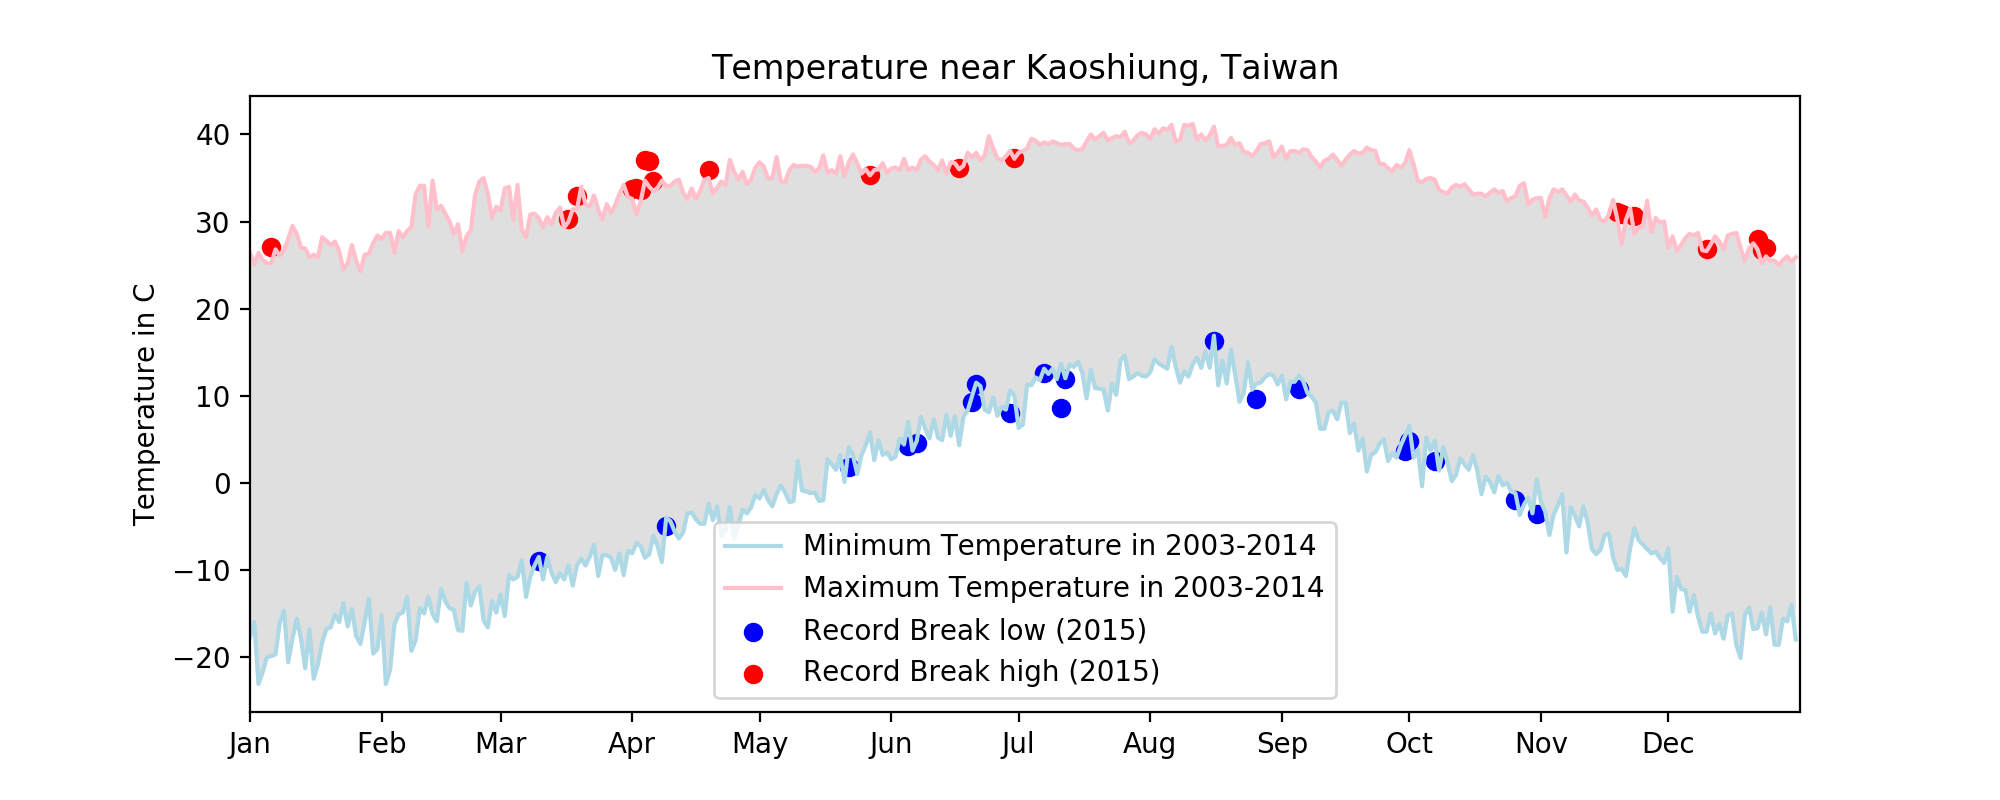

In [10]:
plt.figure(figsize = [10, 4])

# Draw record high and record low in 2003-2014 and fill between the two curves. 
plt.plot(range(365), record_min, color = 'lightblue', label = 'Minimum Temperature in 2003-2014')
plt.plot(range(365), record_max, color = 'pink', label = 'Maximum Temperature in 2003-2014')
plt.fill_between(range(365), record_min['Data_Value'],  record_max['Data_Value'], facecolor = 'grey', alpha = .25);

# If the records are broken in 2015, the date and temperature will be shown by dots
plt.scatter(list(map(to_days, list(lower.index))), lower['Data_Value'], color = 'blue', 
            label = 'Record Break low (2015)')
plt.scatter(list(map(to_days, list(higher.index))), higher['Data_Value'], color = 'red',
            label = 'Record Break high (2015)')

# set the x tick labels
plt.xticks(locs, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']);
plt.ylabel('Temperature in C')
plt.title('Temperature near Kaoshiung, Taiwan')
plt.legend(loc = 8)
plt.xlim(0, 365)
plt.show()

<IPython.core.display.Javascript object>


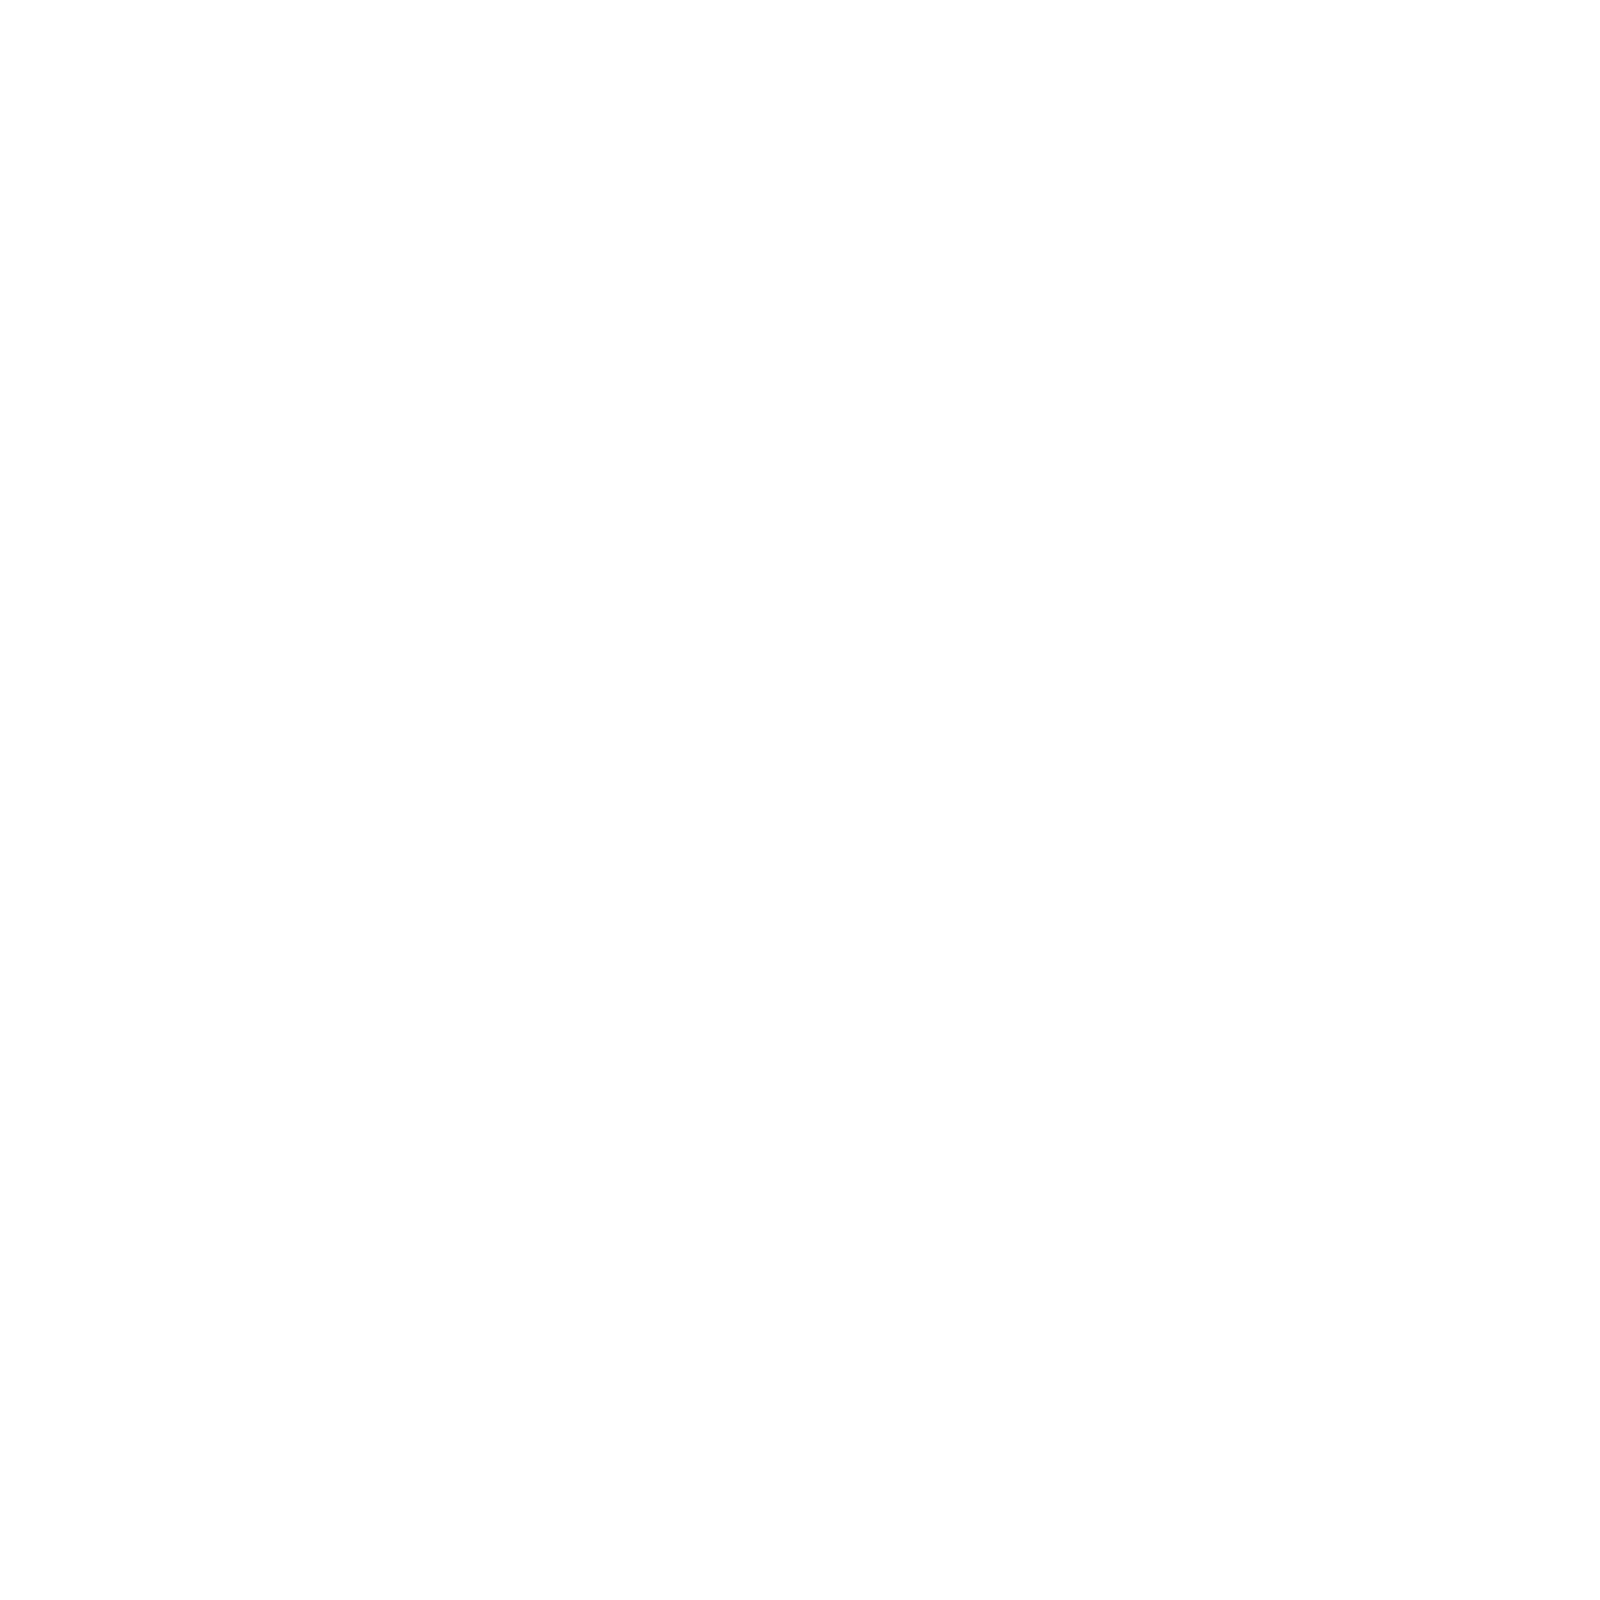

In [11]:
def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(18,'93c648398ff85fad51308f4ff8d11c2e8d8e66392462ffe79f3fb628')